In [2]:
import lsdb
print(lsdb.__version__)

from tqdm import tqdm
from pathlib import Path
import pandas as pd
import textwrap
from dask.distributed import Client

import numexpr as ne
ne.set_num_threads(32)   # pick a sensible value
print(ne.detect_number_of_cores())
print(ne.get_num_threads())

0.6.3
128
32


In [3]:
client = Client(n_workers=4, memory_limit="50GiB", threads_per_worker=1)
# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:17355
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:8645'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:24367'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:8751'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:28355'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:8541 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:8541
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:9600
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:11411 name: 2
INFO:distr

Dask is running at: http://127.0.0.1:8787/status


In [4]:
hats_dir = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB")
from lsdb.core.search import ConeSearch

cone_search = ConeSearch(ra=250, dec=-40, radius_arcsec=7 * 3600)

dia_object_cat = lsdb.open_catalog(hats_dir / "diaobject_cat_test", search_filter=cone_search, columns=["diaObjectId", "ra", "dec"])
dia_source_cat = lsdb.open_catalog(hats_dir / "diasource_cat_test", search_filter=cone_search, columns = ["diaObjectId", 'diaSourceId', 'ssObjectId',"ra", "dec"])
dia_object_cat_nested = lsdb.open_catalog(hats_dir / "dia_object_lc", search_filter=cone_search, columns=["diaObjectId",  "ra", "dec", "diaSource"])


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - from_lsdb_dataframe'}>)

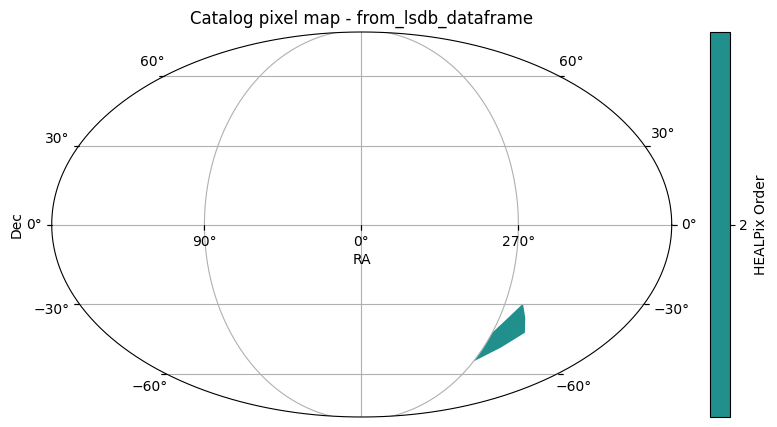

In [5]:
dia_object_cat.plot_pixels()

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - diasource_cat_test'}>)

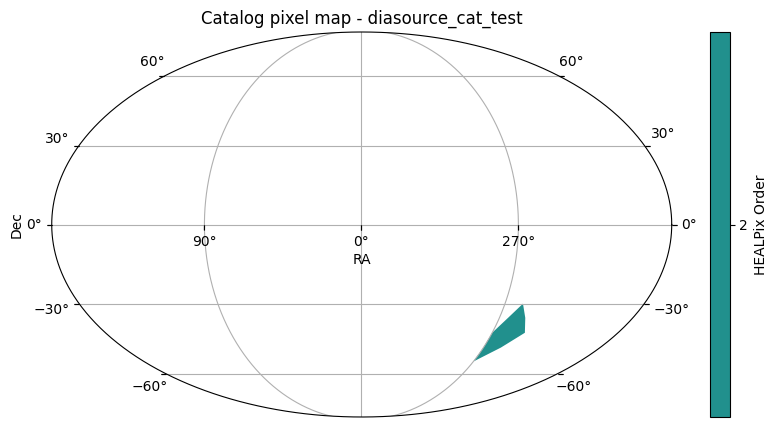

In [6]:
dia_source_cat.plot_pixels()

In [8]:
dia_object_cat_nested 

,diaObjectId,ra,dec,diaSource
npartitions=1,,,,
"Order: 2, Pixel: 165",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<diaSourceId: [int64], apFlux: [double],..."


In [7]:
import pyarrow.parquet as pq
dia_path = '/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/diaobject_cat_test/from_lsdb_dataframe/dataset/Norder=7/Dir=170000/Npix=176179.parquet'
dia_lc_path = '/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/dia_object_lc/dia_object_lc/dataset/Norder=7/Dir=170000/Npix=176179.parquet'
dia_source_path = '/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/diasource_cat_test/dataset/Norder=7/Dir=170000/Npix=176179.parquet'

dia_parquet_file_lc = pq.ParquetFile(dia_lc_path)
dia_parquet_file = pq.ParquetFile(dia_path)
dia_source_parquet_file = pq.ParquetFile(dia_source_path)

import numpy as np

size_bytes = os.path.getsize(dia_path)
size_mb = size_bytes / (1024 ** 2)  # Convert to MB

print(f"Size: {size_bytes:,} bytes ({size_mb:.2f} MB)")

size_bytes = os.path.getsize(dia_lc_path)
size_mb = size_bytes / (1024 ** 2)  # Convert to MB

print(f"Size: {size_bytes:,} bytes ({size_mb:.2f} MB)")

size_bytes = os.path.getsize(dia_source_path)
size_mb = size_bytes / (1024 ** 2)  # Convert to MB

print(f"Size: {size_bytes:,} bytes ({size_mb:.2f} MB)")

FileNotFoundError: [Errno 2] Failed to open local file '/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/diaobject_cat_test/from_lsdb_dataframe/dataset/Norder=7/Dir=170000/Npix=176179.parquet'. Detail: [errno 2] No such file or directory

In [ ]:
def parquet_stats(parquet_file):
    """Return size, length, type, percent, and density for each column in a parquet file."""
    num_cols = parquet_file.metadata.num_columns
    sizes = np.zeros(num_cols)
    lengths = np.zeros(num_cols)
    row_groups = parquet_file.metadata.num_row_groups

    for rg in range(row_groups):
        for col in range(num_cols):
            sizes[col] += parquet_file.metadata.row_group(rg).column(col).total_compressed_size
            lengths[col] += parquet_file.metadata.row_group(rg).column(col).num_values

    first_row_group = parquet_file.metadata.row_group(0)
    names = [first_row_group.column(col).path_in_schema.removesuffix(".list.element")
             for col in range(num_cols)]
    types = [first_row_group.column(col).physical_type for col in range(num_cols)]

    df = pd.DataFrame({
        "name": names,
        "size": sizes,
        "length": lengths,
        "type": types
    })
    df["percent"] = df["size"] / df["size"].sum() * 100
    df["density"] = df["size"] / df["length"]
    return df

# Load parquet files
dia_parquet_file = pq.ParquetFile(dia_path)
dia_parquet_file_lc = pq.ParquetFile(dia_lc_path)
dia_source_parquet_file = pq.ParquetFile(dia_source_path)

# Get stats with renamed columns
df_dia = parquet_stats(dia_parquet_file).rename(columns={
    "size": "size_dia", "length": "len_dia", "type": "type_dia",
    "percent": "percent_dia", "density": "density_dia"
})
df_lc = parquet_stats(dia_parquet_file_lc).rename(columns={
    "size": "size_lc", "length": "len_lc", "type": "type_lc",
    "percent": "percent_lc", "density": "density_lc"
})
df_source = parquet_stats(dia_source_parquet_file).rename(columns={
    "size": "size_source", "length": "len_source", "type": "type_source",
    "percent": "percent_source", "density": "density_source"
})

# Merge on the union of column names
merged_all = pd.merge(df_dia, df_lc, on="name", how="outer")
merged_all = pd.merge(merged_all, df_source, on="name", how="outer")

# Sort for readability
merged_all = merged_all.sort_values("name")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
merged_all

In [35]:
dia_source_cat_0 = dia_source_cat.partitions[0].compute()
dia_object_cat_0 = dia_object_cat.partitions[0].compute()

In [40]:
dia_object_cat_nested_0 = dia_object_cat_nested.partitions[0].compute()

In [21]:
n_src = np.unique(dia_source_cat_0['diaObjectId'], return_counts=True)

In [36]:
mem_bytes = dia_object_cat_0.memory_usage(index=True, deep=True).sum()
print(f"Memory usage: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")

Memory usage: 456,729,199 bytes (435.57 MB)


In [33]:
mem_bytes = dia_source_cat_0.memory_usage(index=True, deep=True).sum()
print(f"Memory usage: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")

Memory usage: 279,390,018 bytes (266.45 MB)


Memory usage: 1,867,421,982 bytes (1780.91 MB)


In [41]:
dia_object_cat_nested_0_like_obj = dia_object_cat_nested_0[dia_object_cat_nested_0.columns[:-1]]

Memory usage for object part in nested: 456,729,199 bytes (435.57 MB)


In [52]:

mem_bytes = dia_object_cat_0.memory_usage(index=True, deep=True).sum()
print(f"Memory usage for objects: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")
mem_bytes = dia_source_cat_0.memory_usage(index=True, deep=True).sum()
print(f"Memory usage for sources: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")
mem_bytes = dia_object_cat_nested_0.memory_usage(index=True, deep=True).sum()
print(f"Memory usage for nestedFrame: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")
mem_bytes = dia_object_cat_nested_0_like_obj.memory_usage(index=True, deep=True).sum()
print(f"Memory usage for object part in nestedFrame: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")
mem_bytes = dia_object_cat_nested_0[dia_object_cat_nested_0.columns[-1:]].memory_usage(index=True, deep=True).sum()
print(f"Memory usage for just nested sources part in nestedFrame: {mem_bytes:,} bytes ({mem_bytes / (1024**2):.2f} MB)")

Memory usage for objects: 456,729,199 bytes (435.57 MB)
Memory usage for sources: 279,390,018 bytes (266.45 MB)
Memory usage for nestedFrame: 1,867,421,982 bytes (1780.91 MB)
Memory usage for object part in nestedFrame: 456,729,199 bytes (435.57 MB)
Memory usage for just nested sources part in nestedFrame: 1,413,113,943 bytes (1347.65 MB)


In [ ]:
count_nested(nf, "nested")

In [53]:
len(dia_source_cat_0)

316634

In [38]:
len(dia_object_cat_nested_0)

302645

In [37]:
len(dia_object_cat_0)

302645

In [72]:
from nested_pandas.utils import count_nested
dia_object_cat_nested_0 = count_nested(dia_object_cat_nested_0, "diaSource")

In [7]:
dia_object_cat

,diaObjectId,ra,dec
npartitions=5,,,
"Order: 4, Pixel: 2648",int64[pyarrow],double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 2649",...,...,...
"Order: 4, Pixel: 2650",...,...,...
"Order: 4, Pixel: 2651",...,...,...
"Order: 4, Pixel: 2652",...,...,...


In [10]:
dia_object_cat_0 = dia_object_cat.partitions[0].compute() 
dia_object_cat_1 = dia_object_cat.partitions[1].compute() 
dia_object_cat_2 = dia_object_cat.partitions[2].compute() 
dia_object_cat_3 = dia_object_cat.partitions[3].compute() 
dia_object_cat_4 = dia_object_cat.partitions[4].compute() 



In [90]:
dia_object_cat_0

,diaObjectId,ra,dec
_healpix_29,,,
2982358998015055494,24958967776018433,254.601144,-42.886475
2982364844334226803,24958967776018434,254.546842,-42.885011
...,...,...,...
2982472806150342025,24958981875695677,253.779525,-42.33273
2982472831534944241,24958981875695681,253.771636,-42.326884


In [73]:
dia_object_cat_0['diaObjectId']

_healpix_29
2982358998015055494    24958967776018433
2982364844334226803    24958967776018434
                             ...        
2982472806150342025    24958981875695677
2982472831534944241    24958981875695681
Name: diaObjectId, Length: 24167, dtype: int64[pyarrow]

In [75]:
np.unique(dia_object_cat_0['diaObjectId'], return_counts=True)

(array([24958966175891472, 24958966175891497, 24958966175891518, ...,
        24958982006767713, 24958982006767717, 24958982018826298]),
 array([1, 2, 1, ..., 1, 1, 1]))

In [93]:
dia_source_cat

,diaObjectId,diaSourceId,ssObjectId,ra,dec
npartitions=1,,,,,
"Order: 2, Pixel: 165",int64[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow]


In [5]:
dia_source_cat_0 = dia_source_cat.partitions[0].compute() 

In [ ]:
dia_source_cat_0

In [32]:
len(dia_source_cat_0)

869631

In [20]:
dia_object_cat_nested_0 = dia_object_cat_nested.partitions[0].compute() 
dia_object_cat_nested_1 = dia_object_cat_nested.partitions[1].compute() 
dia_object_cat_nested_2 = dia_object_cat_nested.partitions[2].compute() 
dia_object_cat_nested_3 = dia_object_cat_nested.partitions[3].compute() 
dia_object_cat_nested_4 = dia_object_cat_nested.partitions[4].compute() 

In [25]:
from nested_pandas.utils import count_nested
dia_object_cat_nested_0_count = count_nested(dia_object_cat_nested_0, 'diaSource')
dia_object_cat_nested_1_count = count_nested(dia_object_cat_nested_1, 'diaSource')
dia_object_cat_nested_2_count = count_nested(dia_object_cat_nested_2, 'diaSource')
dia_object_cat_nested_3_count = count_nested(dia_object_cat_nested_3, 'diaSource')
dia_object_cat_nested_4_count = count_nested(dia_object_cat_nested_4, 'diaSource')

In [33]:
len_of_nested = dia_object_cat_nested_0_count['n_diaSource'].sum() + dia_object_cat_nested_1_count['n_diaSource'].sum() + dia_object_cat_nested_2_count['n_diaSource'].sum() + dia_object_cat_nested_3_count['n_diaSource'].sum() + dia_object_cat_nested_4_count['n_diaSource'].sum()

In [37]:
dia_object_cat_nested_0_count[['diaObjectId', 'n_diaSource']]

,diaObjectId,n_diaSource
_healpix_29,,
2982358998015055494,24958967776018433,1
2982364844334226803,24958967776018434,2
...,...,...
2982472806150342025,24958981875695677,1
2982472831534944241,24958981875695681,1


In [35]:
len_of_nested/len(dia_source_cat_0)

np.float64(4.260246012389163)

In [38]:
# Concatenate them into one DataFrame
dia_object_cat_all_counts = pd.concat([
    dia_object_cat_nested_0_count[['diaObjectId', 'n_diaSource']],
    dia_object_cat_nested_1_count[['diaObjectId', 'n_diaSource']],
    dia_object_cat_nested_2_count[['diaObjectId', 'n_diaSource']],
    dia_object_cat_nested_3_count[['diaObjectId', 'n_diaSource']],
    dia_object_cat_nested_4_count[['diaObjectId', 'n_diaSource']],
])

In [39]:
dia_object_cat_all_counts

,diaObjectId,n_diaSource
_healpix_29,,
2982358998015055494,24958967776018433,1
2982364844334226803,24958967776018434,2
...,...,...
2986455295514412269,24958982174539919,1
2986455178660150705,24958982174539920,1


In [44]:
dia_source_cat_0[dia_source_cat_0 ['diaObjectId'] == 0]

,diaObjectId,diaSourceId,ra,dec
_healpix_29,,,,
2982331335621562993,0,24958976497025038,254.878015,-43.224983
2982332319378382734,0,24958967773921331,254.981138,-43.098017
...,...,...,...,...
2986629474485490496,0,24958976186646829,256.216681,-38.762848
2986629474615255798,0,24958978195718276,256.215896,-38.762288


In [41]:
n_diaSource_per_object = (
    dia_source_cat_0
    .groupby('diaObjectId')['diaSourceId']
    .count()
    .reset_index()
    .rename(columns={'diaSourceId': 'n_diaSource'})
)

In [52]:
# First rename one of the n_diaSource columns to distinguish them
n_diaSource_per_object_renamed = n_diaSource_per_object.rename(
    columns={"n_diaSource": "n_diaSource_from_sources"}
)

# Merge on diaObjectId
merged_counts = dia_object_cat_all_counts.merge(
    n_diaSource_per_object_renamed, on="diaObjectId", how="outer"
)


In [70]:
n_diaSource_per_object_renamed['diaObjectId'].unique()

<ArrowExtensionArray>
[                0, 24958966162259969, 24958966162259982, 24958966162259986,
 24958966162259989, 24958966162259992, 24958966162259993, 24958966162259999,
 24958966162260019, 24958966162260116,
 ...
 24958982230638593, 24958982230638620, 24958982230638625, 24958982230638626,
 24958982230638628, 24958982230638639, 24958982230638650, 24958982230638678,
 24958982230638712, 24958982230638740]
Length: 513887, dtype: int64[pyarrow]

In [71]:
merged_counts['diaObjectId'].unique()

<ArrowExtensionArray>
[                0, 24958966162259969, 24958966162259982, 24958966162259986,
 24958966162259989, 24958966162259992, 24958966162259993, 24958966162259999,
 24958966162260019, 24958966162260116,
 ...
 24958982230638593, 24958982230638620, 24958982230638625, 24958982230638626,
 24958982230638628, 24958982230638639, 24958982230638650, 24958982230638678,
 24958982230638712, 24958982230638740]
Length: 513887, dtype: int64[pyarrow]

In [63]:
from matplotlib import pyplot as plt
import numpy as np

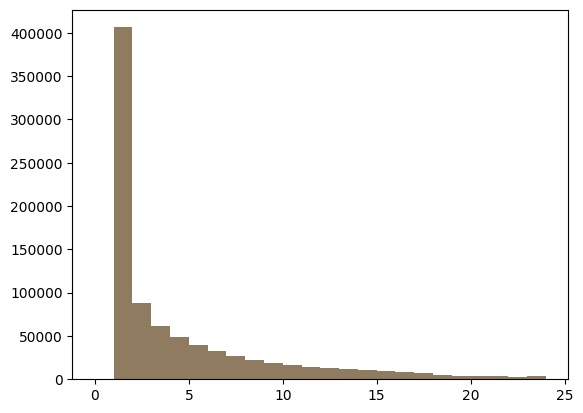

In [68]:
plt.hist(merged_counts['n_diaSource_from_sources'], bins=np.arange(0, 25, 1));
plt.hist(merged_counts['n_diaSource'], bins=np.arange(0, 25, 1), alpha=0.5);

In [56]:
mismatched = merged_counts[
    merged_counts['n_diaSource'] != merged_counts['n_diaSource_from_sources']
]

mismatched

,diaObjectId,n_diaSource,n_diaSource_from_sources
499627,24958974568693895,1.0,3
572445,24958976044041003,3.0,1


# Check if duplicating

In [76]:
root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Recursively gather every *.parquet file
parquet_files = sorted(root.rglob("*.parquet"))

print(f"Found {len(parquet_files):,} parquet files")


root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Find all DiaObject.parquet files
diaobject_files = sorted(root.rglob("DiaObject.parquet"))
print(f"Found {len(diaobject_files)} DiaObject.parquet files")

diaobject_df_list = []
diasource_df_list = []

for obj_path in tqdm(diaobject_files):
    try:
        # Load DiaObject.parquet
        diaobject_df_list.append(pd.read_parquet(obj_path))
    except Exception as e:
        print(f"Failed to read {obj_path}: {e}")
    
    # Look for DiaSource.parquet in the same directory
    #source_path = obj_path.parent / "DiaSource.parquet"
    #if source_path.exists():
    #    try:
    #        diasource_df_list.append(pd.read_parquet(source_path))
    #    except Exception as e:
    #        print(f"Failed to read {source_path}: {e}")

# Concatenate results
diaobject_df = pd.concat(diaobject_df_list, ignore_index=True) if diaobject_df_list else pd.DataFrame()
#diasource_df = pd.concat(diasource_df_list, ignore_index=True) if diasource_df_list else pd.DataFrame()

print(f"DiaObject DataFrame shape: {diaobject_df.shape}")
#print(f"DiaSource DataFrame shape: {diasource_df.shape}")


Found 440 parquet files
Found 175 DiaObject.parquet files


100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


DiaObject DataFrame shape: (43304705, 190)


In [79]:
diaObject_counts = np.unique(diaobject_df['diaObjectId'], return_counts=True)

In [88]:
np.max(diaObject_counts[1])

np.int64(265)

np.int64(24963316523730677)

(array([9.021468e+06, 1.910100e+05, 7.288300e+04, 2.882800e+04,
        1.125000e+04, 4.270000e+03, 1.252000e+03, 3.400000e+02,
        5.600000e+01, 2.000000e+00]),
 array([  1. ,  27.4,  53.8,  80.2, 106.6, 133. , 159.4, 185.8, 212.2,
        238.6, 265. ]),
 <BarContainer object of 10 artists>)

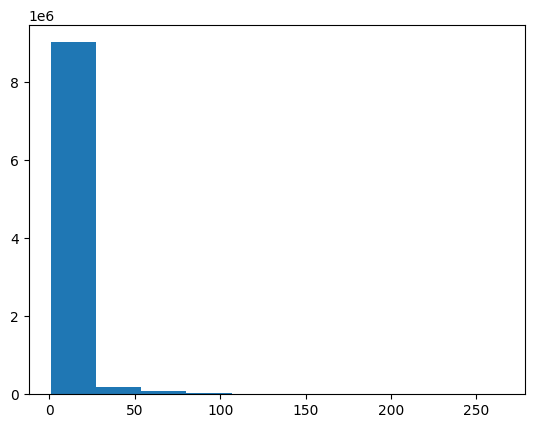

In [89]:
plt.hist(diaObject_counts[1])